In [109]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [110]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


# Load and Prepare the Dataset

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Add, PReLU, UpSampling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split

In [2]:
# Initialize lists to hold the images and labels
ship = []
no_ship = []

# Load ship images
for f in glob.iglob("C:/Users/ceagbaraji/Documents/Data/ship/*.png"):
    img = cv2.imread(f)
    img = cv2.resize(img, (224, 224))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    ship.append(img)

# Load no_ship images
for f in glob.iglob("C:/Users/ceagbaraji/Documents/Data/no_ship/*.png"):
    img = cv2.imread(f)
    img = cv2.resize(img, (224, 224))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    no_ship.append(img)

In [3]:
# Convert lists to numpy arrays
ship = np.array(ship)
no_ship = np.array(no_ship)
All = np.concatenate((no_ship, ship))

In [4]:
no_ship.shape

(3000, 224, 224, 3)

In [5]:
ship.shape

(1000, 224, 224, 3)

In [6]:
np.random.choice(10, 5, replace=False)

array([2, 7, 3, 6, 4])

# Viasualize the Dataset

In [7]:
def plot_random(no_ship, ship, num=5):
    no_ship_imgs = no_ship[np.random.choice(no_ship.shape[0], num, replace=False)]
    ship_imgs = ship[np.random.choice(ship.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('no ship')
        plt.imshow(no_ship_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('ship')
        plt.imshow(ship_imgs[i])

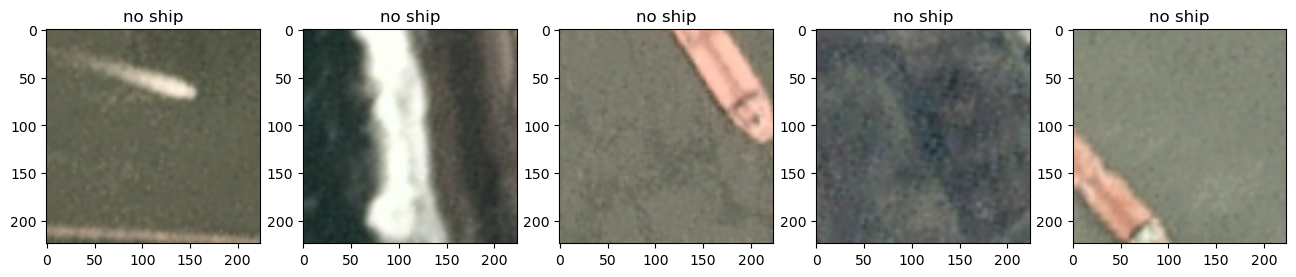

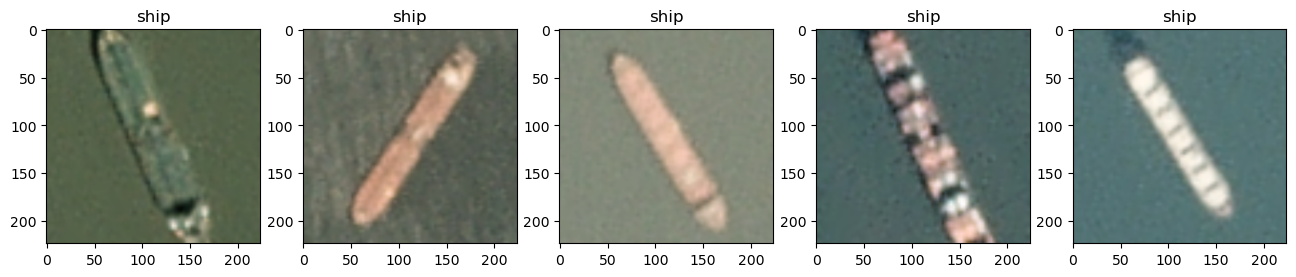

In [8]:
plot_random(no_ship, ship, num=5)

In [9]:
# Prepare labels
ship_labels = np.ones(len(ship))
no_ship_labels = np.zeros(len(no_ship))

In [10]:
# Concatenate data and labels
images = np.concatenate((no_ship, ship), axis=0)
labels = np.concatenate((no_ship_labels, ship_labels), axis=0)

In [11]:
# Normalize the data to [0, 1] range
images = images / 255.0

# Split the Dataset

In [12]:
# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Design DenseNet-201

In [13]:
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Add, PReLU, UpSampling2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

In [14]:
# Define the DenseNet-201 model
input_shape = (224, 224, 3)
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers to prevent them from being trained during fine-tuning
base_model.trainable = False

# Add custom layers on top of DenseNet-201 for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification (sigmoid activation)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model

In [16]:
# Early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
# Train the model
history = model.fit(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels), batch_size=32, callbacks=[early_stopping])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8629 - loss: 0.3438 - val_accuracy: 0.9600 - val_loss: 0.1180
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9597 - loss: 0.1134 - val_accuracy: 0.9613 - val_loss: 0.1024
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9736 - loss: 0.0825 - val_accuracy: 0.9850 - val_loss: 0.0570
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9861 - loss: 0.0476 - val_accuracy: 0.9712 - val_loss: 0.0719
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9910 - loss: 0.0382 - val_accuracy: 0.9862 - val_loss: 0.0455
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9947 - loss: 0.0241 - val_accuracy: 0.9900 - val_loss: 0.0414
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9978 - loss: 0.0173 - val_accuracy: 0.9887 - val_loss: 0.0413
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9991 - loss: 0.0124 - val_accu

# Evaluate the Model

In [18]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9925 - loss: 0.0310
Test Loss: 0.0401
Test Accuracy: 0.9887


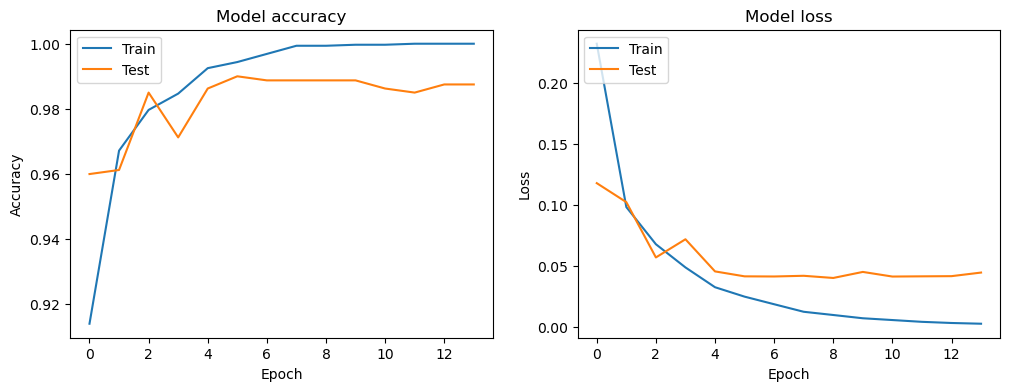

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [19]:
# Predict the labels on the test set
pred_labels = (model.predict(test_images) > 0.5).astype("int32")

25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


In [20]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[610   6]
 [  3 181]]


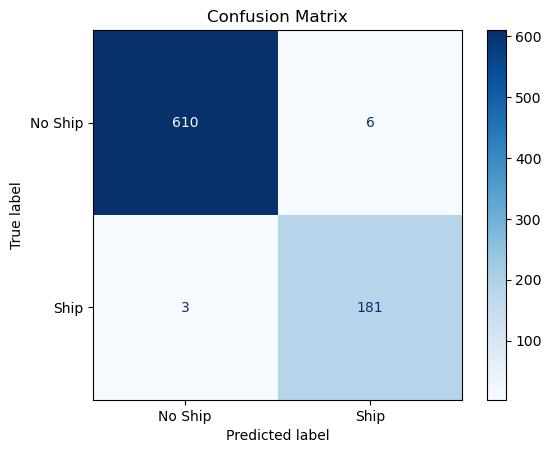

In [21]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Ship', 'Ship'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Generate and print classification report
class_report = classification_report(test_labels, pred_labels, target_names=['No Ship', 'Ship'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

     No Ship       1.00      0.99      0.99       616
        Ship       0.97      0.98      0.98       184

    accuracy                           0.99       800
   macro avg       0.98      0.99      0.98       800
weighted avg       0.99      0.99      0.99       800

